## Problem Set 5: Quantile Regression
_MaCSS 222 Applied Statistics II Spring 2025_   
_Bryan Graham_   
_University of California at Berkeley_      
_March 2025_   
<br>
<br>
The GSI, Jinglin Yang (jinglin.yang@berkeley.edu), will handle the logistics of problem set collection.    

Working with peers on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials.    

This problem set reviews the material on quantiles and quantile regression developed in lecture.

#### Code citation:
<br>
Graham, Bryan S. (2025). "Quantile Regression Python Juypter Notebook," (Version 1.0) [Computer program]. Available at http://bryangraham.github.io/econometrics/ (Accessed 27 May 2025)
<br>
<br>

In [1]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from scipy.interpolate import griddata

The datafiles for this notebook are available on the course GitHub repository. We will use a 1996 labor force survey from Brazil (PNAD). We will use this dataset to explore the relationship between schooling and earnings.

In [2]:
# Directory where data files are located
data = '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Data/'
graphics = '/Users/chris/Library/Mobile Documents/com~apple~CloudDocs/Berkeley/COMPSS 222 Applied Statistics II/Graphics/'

In [3]:
pnad96 = pd.read_csv(data + 'Brazil_1996PNAD.out', header = 0, sep='\t+', engine='python')

# Find relevant estimation subsample: in prime aged men with positive monthly earnings
sample = pnad96.loc[(pnad96['MONTHLY_EARNINGS'] > 0) & (pnad96['AgeInDays'] >= 20)  & (pnad96['AgeInDays'] < 65)].copy()

#Display the first few rows of the dataframe
sample.describe()

,AgeInDays,YRSSCH,MONTHLY_EARNINGS,Father_NoSchool,Father_Incomplete1stPrimary,Father_Complete1stPrimary,Father_Incomplete2ndPrimary,Father_Complete2ndPrimary,Father_IncompleteSecondary,Father_CompleteSecondary,...,Mother_NoSchool,Mother_Incomplete1stPrimary,Mother_Complete1stPrimary,Mother_Incomplete2ndPrimary,Mother_Complete2ndPrimary,Mother_IncompleteSecondary,Mother_CompleteSecondary,Mother_IncompleteHigher,Mother_CompleteHigher,Mother_DontKnow
count,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,...,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000,57651.000000
mean,37.971992,5.747324,632.051985,0.287575,0.205027,0.138419,0.033425,0.053685,0.052159,0.038802,...,0.341052,0.188288,0.134985,0.040849,0.064370,0.031951,0.044249,0.016392,0.052991,0.084873
std,11.126182,4.231994,1105.739430,0.452636,0.403725,0.345342,0.179746,0.225397,0.222349,0.193126,...,0.474067,0.390945,0.341710,0.197943,0.245413,0.175871,0.205650,0.126978,0.224018,0.278695
min,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.943190,3.000000,174.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.750170,5.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.895960,8.000000,600.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,64.996570,15.000000,50000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Recall the the $\tau^{th}$ quantile of the random variable $Y$ is the value of $Y$, such that $100\tau$ percent of units in the population have a value of $Y$ less than the $\tau^{th}$ quantile and $100(1-\tau)$ have a value above. We will denote the $\tau^{th}$ quantile $Y$ by one of $Q_{\tau}\left(Y\right)$, $\theta_{\tau}$, or $\theta(\tau)$ . All three of these notations are used in practice.
<br>
<br>
Our development of quantiles will assume that $Y$ is a continuously-valued random variable with a cummulative distribution function (CDF) $$F_Y(y)=\Pr(Y \leq y),$$
that is strictly increasing in $y$. In practice many random variables have point masses. For example wage distributions often have point masses at the statutory minimum wage level as well as at various focal wage levels (e.g., $30 dollars an hour). This creates complications both theoretically and practically. We will ignore the theoretical complications, but will cover some practical approaches to these issues in this problem set.
<br>
<br>
At the end of the problem set you should be well positioned to conduct a quantile regression analysis using a dataset of your own choosing.


## Quantiles: basic definitions and examples

This first block of code below reproduces the CDF and quantile function figures used to define quantiles in lecture.
<br>
<br>
The plotted CDF is for a Weibull random variable with pdf:
$$f\left(y;\alpha,\beta\right)=\beta\alpha y^{\alpha-1}\exp\left(-\beta y^{\alpha}\right).$$
Here $\alpha$ is called the shape parameter, while $\beta$ is called the scale parameter. The parameterization above is used widely in econometrics and called the "first alternative parameterization" in the Wikipedia entry for the Weibull distribution. There are other parameterizations of the Weibull distribution and it is easy to get confused; make sure any result you use applies to the appropriate parameterization. The Weibull distribution is widely used in duration analysis to model "time-to-event" data.
<br>
<br>
The expected value of $Y\sim\mathrm{Weibull}\left(\alpha,\beta\right)$ equals:
$$\mathbb{E}\left[Y\right]=\beta^{-\frac{1}{\alpha}}\Gamma\left(1+\frac{1}{\alpha}\right) $$
where $\Gamma()$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). The $\tau^{th}$ quantile of Y equals
$$Q_{\tau}\left(Y\right)=\left[-\frac{1}{\beta}\ln\left(1-\tau\right)\right]^{\frac{1}{\alpha}}.$$
The figure below sets $\alpha = \beta =2$. The median, denoted by $\theta_{\frac{1}{2}}$ is shown on the figures.


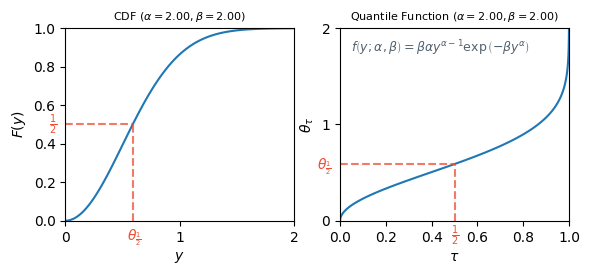

In [5]:
#        Y ~ Weibull(a,b)
#     E[Y] = (b**(-1/a))*Gamma(1+1/a)
# Q_Y(1/2) = (b^(-1/a))*ln(2)**(1/a)

a = 2                                # Weibull shape parameter
b = 2                                # Weibull **rate** parameter (first alternative "econometrics" formulation) 
med_Y = (b**(-1/a))*np.log(2)**(1/a) # Median of Weibull(a,b) rv

# Generate y-values upon which to evaluate the CDF
y = np.linspace(0, 2, 100)

# Calculate the F(y)/CDF values
F_y = sp.stats.weibull_min.cdf(y, a, scale=b**(-1/a))

# Plot CDF and associated quantile function in a two panel figure
fig_quantile_def, sbp = plt.subplots(1,2, figsize=(6.5, 2.5))

ax0 = sbp[0] # Handle for left subplot (cdf)
ax1 = sbp[1] # Handle for right subplot (quantile)

# CDF
ax0.set_xlabel(r'$y$')
ax0.set_xticks([0, 1, 2])
ax0.set_ylabel(r'$F(y)$')
ax0.set_yticks([0, 0.20, 0.40, 0.60, 0.80, 1])
ax0.plot(y, F_y)
ax0.set_title(r'CDF ($\alpha={:.2f}, \beta={:.2f})$'.format(a, b), fontsize=8)
ax0.plot((med_Y, med_Y), (0, 1/2), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=theta(1/2)
ax0.plot((0, med_Y), (1/2, 1/2), color='#ED4E33', alpha = 0.75, linestyle='dashed')    # the horizontal line with y=1/2)
ax0.text(med_Y-0.05, -0.10, r'$\theta_{\frac{1}{2}}$', fontsize=10, color='#ED4E33')
ax0.text(-0.14, 1/2-0.025, r'$\frac{1}{2}$', fontsize=10, color='#ED4E33')
ax0.set_xlim(0, 2)
ax0.set_ylim(0, 1)

# Quantile
ax1.set_xlabel(r'$\tau$')
ax1.set_xticks([0, 0.20, 0.40, 0.60, 0.80, 1])
ax1.set_ylabel(r'$\theta_{\tau}$')
ax1.set_yticks([0, 1, 2])
ax1.plot(F_y,y)
ax1.set_title(r'Quantile Function ($\alpha={:.2f}, \beta={:.2f})$'.format(a, b), fontsize=8)
ax1.plot((0, 1/2), (med_Y, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=theta(1/2)
ax1.plot((1/2, 1/2), (0, med_Y), color='#ED4E33', alpha = 0.75, linestyle='dashed')    # the horizontal line with y=1/2)
ax1.text(-0.10, med_Y-0.05, r'$\theta_{\frac{1}{2}}$', fontsize=10, color='#ED4E33')
ax1.text(1/2-0.015, -0.20, r'$\frac{1}{2}$', fontsize=10, color='#ED4E33')
ax1.text(0.05, 1.75, r'$f\left(y;\alpha,\beta\right)=\beta\alpha y^{\alpha-1}\exp\left(-\beta y^{\alpha}\right)$', fontsize=9, color='#53626F')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 2)

# Save result
plt.savefig(graphics+'weibull_cdf_qf.png')

## Quantile estimation and inference
The approach to quantile estimation developed in lecture was very intuitive. Let $\theta_{\tau}$ denote the $\tau^{th}$ quantile of $Y$. Recall that $\theta_{\tau}$ coincides with the value of $Y$, such that $100\tau$ percent of units in the population have a value of $Y$ below it and $100(1-\tau)$ have a value above it. 
<br>
<br>
Let $Y_1,\dots,Y_N$ be a simple random sample of size $N$ drawn from the population $F_Y(Y)$. Our quantile estimate, $\hat{\theta}_{\tau}$, is simply the value of $Y$ _in our sample_ such that roughly $100\tau$ percent of our sample observations lie below $\hat{\theta}_{\tau}$ and the balance above. Note that we cannot typically find a $\hat{\theta}_{\tau}$ such that _exactly_ $100\tau$ sample units lie below (due to finiteness of $N$), but with $N$ large enough we can come quite close.
<br>
<br>
Let $Y_{\left(1\right)},Y_{\left(2\right)},\ldots,Y_{\left(N\right)}$ be the [order statistics](https://en.wikipedia.org/wiki/Order_statistic) (from smallest to largest) of our random sample. Next find the integer $l$ such that
$$\frac{l}{N+1}\leq\tau<\frac{l+1}{N+1}.$$ 
We estimate $\theta_{\tau}$ by the $\tau^{th}$ sample quantile:
$$\boxed{\hat{\theta}_{\tau}=\frac{Y_{\left(l\right)}+Y_{\left(l+1\right)}}{2}.}$$
With $N=10$ and $\tau=1/2$ we find that $l=5$ and
$$\hat{\theta}_{1/2}=\frac{Y_{\left(5\right)}+Y_{\left(6\right)}}{2}.$$
This is probably the definition of the sample median you learned in middle school or high school. The _quantile_ function in the _numpy_ module makes it very simple to compute sample quantiles. It turns out there are many asymptotically equivalent estimates of the $\theta_{\tau}$. A close read of the quantile function [documentation](https://numpy.org/doc/2.1/reference/generated/numpy.quantile.html) gives you a sense of the options. Setting the _method_ parameter to "midpoint" delivers the estimator described here.
<br>
<br>
### Using order statistics to construct confidence intervals
As described in lecture we can also use an interesting relationship between quantiles and the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) to construct confidence intervals. We specifically consider the order statistics interval:
$$[Y_{(j)},Y_{(k)}]$$
for some pair of $j$ and $k$ with $j<k$. The challenge is to choose $j$ and $k$ to achieve a target coverage level (e.g., 95 percent). This method is intuitive: we think, for example, that the true population median should line between the 2nd and 8th order statistics in a random sample of 10 units. To justify this approach, as well as determine its coverage properities, we exploit the following observations.
1. The _ex ante_ probability that a random draw lies below $\theta_{\tau}$ is $\tau$.
2. For $Y_{(j)}$ to lie below $\theta_{\tau}$ it must be the case that _at least_ $j$ draws in the sample lie below $\theta_{\tau}$. We can compute this probability by evaluating the Binomial pmf for each of $i=j,j+1,\ldots,N$ "successes" out of $N$ trials with Bernoulli success probability equal to $\tau$ and summing them up.
3. For $Y_{(k)}$ to lie above $\theta_{\tau}$ it must be the case that _no more_ that $k-1$ draws in the sample lie below $\theta_{\tau}$
4. To get the _ex ante_ probability of the event "$[Y_{(j)},Y_{(k)}]$ contains $\theta_{\tau}$" we therefore sum the Binomial pmf values at each of $i=j,j+1,\ldots,k-1$ "successes" out of $N$ trials with Bernoulli success probability equal to $\tau$.
    
The actual coverage formula is:
$$\Pr\left(Y_{\left(j\right)}\leq\theta_{\tau}\leq Y_{\left(k\right)}\right) =\sum_{i=j}^{k-1}\tbinom{N}{i}\tau^{i}\left[1-\tau\right]^{N-i}.$$

The above recipe computes the _exact_ coverage of the order statistics interval. By adjusting our choice of $j$ and $k$ we can typically get actual coverage quite close to, say, $\alpha=0.95$ when $N$ is modestly large. It is rare in empirical work to be able to compute an exact confidence interval, that we can do so here, without making any parametric assumptions about the distribution of $Y$, is remarkable.
<br>
<br>
When $N$ is large it can be difficult to evaluate the coverage on an order statistic interval exactly (large binomial coefficients are difficult to compute). Using the fact that the normal distribution is well-approximated by a binomial we came up with the following procedure for choosing $j$ and $k$.
1. Let $l=\sqrt{N\tau\left(1-\tau\right)}\cdot z^{1-\alpha/2}$ with $z^{1-\alpha/2}$ the $1-\alpha/2$ quantile of a standard normal random variable (sometimes called ``critical values"). With $\alpha = 0.5$ we have $z^{1-\alpha/2}=1.96$.
2. Set $j=\left\lfloor N\tau-l\right\rfloor$  and $k=\left\lceil N\tau+l\right\rceil$ and report the interval $[Y_{(j)},Y_{(k)}]$.

As long as $\tau$ is not to close to either zero or one and $N$ is modestly large, an interval constructed as described above will cover $\theta_{\tau}$ with an _ex ante_ probability of close to $1-\alpha$.

The code block below simulates $S$ samples of size $N$ from a $\mathrm{Weibull}\left(\alpha,\beta\right)$ distribution. For each simulated sample $s=1,\ldots,S$ it computes an 95 percent order statistic confidence interval for $\theta_{\tau}$ and checks whether the interval includes $\theta_{\tau}$. We would expect/hope that about $0.95 \times S$ of the simulated intervals would contain $\theta_{\tau}$. We will check this prediction shortly.

In [6]:
#        Y ~ Weibull(a,b)
#     E[Y] = (b**(-1/a))*Gamma(1+1/a)
# Q_Y(1/2) = (b^(-1/a))*ln(2)**(1/a)
# Q_Y(tau) = (-b^(-1/a))*ln(1-tau)**(1/a)


tau    = 0.50                                         # Quantile of interest (1/2 = median)
alpha  = 0.05                                         # Set confidence level as 1-alpha
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # The critical value from N(0,1),
N  = 50                                               # Number of random draws included in each sample                                                      # which satisfies P(-c\leq N(0,1)\leq c)=1-alpha

a = 1                                     # Weibull shape parameter
b = 1                                     # Weibull **rate** parameter (first alternative "econometrics" formulation) 
theta_tau = (-(1/b)*np.log(1-tau))**(1/a) # Tau-th quantile of Weibull(a,b) rv

l      = ((N*tau*(1-tau))**(1/2))*z_crit   
j      = int(np.floor(N*tau - l))
k      = int(np.ceil(N*tau + l))

S             = 10000             # Number of repeated samples simulated
CI            = np.empty((S,2))   # Matrix for storing two order statistics for each of the s=1...S samples
theta_tau_hat =  np.empty((S,))   # Vector for storing quantile estimates

for s in range (0,S):
    Y                = (b**(-1/a))*np.random.weibull(a, (N,)) # 1...N iid Weibull(a,b) random draws
    X                = np.sort(Y)           # Order statistics corresponding to the random sample Y
    CI[s,:]          = X[j-1],X[k-1]        # Store the corresponding two order statistics (-1 because Python starts from 0)
    theta_tau_hat[s] = np.quantile(X, tau, interpolation='midpoint')  # Calculate the sample tau-th quantile 

### Question 1:
The next block of code generates a plot of the $S$ simulated $Y_{(j)},Y_{(k)}$ order statistics pairs. Provide a narrative description of this figure. Make sure you answer explains the significance of the plot colorings and also why there are no observations below the 45-degree line. Place your answer in a markdown box below the figure.

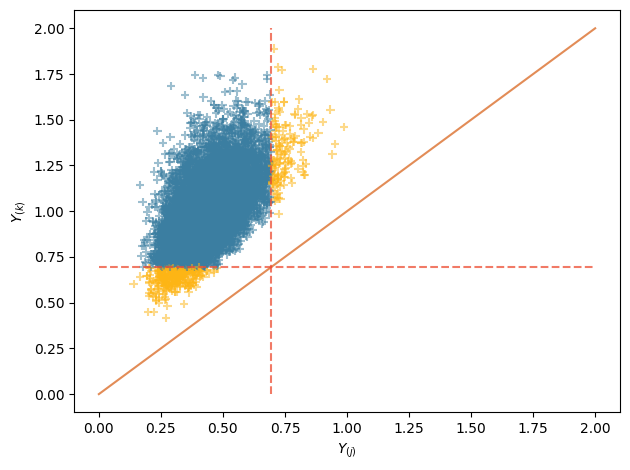

In [7]:
fig_quantile_CI_demo, ax = plt.subplots()

                                                   
ax.set_xlabel(r'$Y_{(j)}$')
ax.set_ylabel(r'$Y_{(k)}$')

col = np.where((CI[:,0]<=theta_tau) & (CI[:,1]>=theta_tau),'#3B7EA1','#FDB515') # the sample with (Xj<=med_Y<=Xk) will 
                # be plotted with the color '#3B7EA1', otherwise, it will be ploted with the color '#FDB515'

ax.scatter(CI[:,0], CI[:,1],color = col, alpha = 0.5, marker = '+') # each point indicates (Xj,Xk) from each sample

plt.plot((0, 2), (0, 2), color='#D9661F', alpha = 0.75) # 45-degree line
plt.plot((theta_tau, theta_tau), (0, 2), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the vertical line with x=med_Y
plt.plot((0, 2), (theta_tau, theta_tau), color='#ED4E33', alpha = 0.75, linestyle='dashed') # the horizontal line with y=med_Y

# Save result
plt.tight_layout()
plt.savefig(graphics+'order_stat_CI_for_quantiles.png')

#### Answer:

This figure shows simulated pairs of order statistics $(Y_{(j)}, Y_{(k)})$, where each point represents the lower and upper bounds of a confidence interval for a quantile (specifically, the median $\theta_{0.5}$) estimated from a bootstrap sample.

- **Blue points** represent samples where the confidence interval **contains** the true quantile value $\theta_{0.5}$. That is, the condition $Y_{(j)} \leq \theta_{0.5} \leq Y_{(k)}$ holds.
- **Yellow points** represent samples where the confidence interval **fails to contain** the true quantile. That is, $\theta_{0.5}$ lies **outside** the interval $[Y_{(j)}, Y_{(k)}]$.

The **45-degree line** corresponds to $Y_{(j)} = Y_{(k)}$. Since $j < k$ and the data is ordered, we always have $Y_{(j)} \leq Y_{(k)}$, so no points fall below the 45-degree line.

The **dashed vertical and horizontal lines** mark the location of $\theta_{0.5}$ on each axis, helping to visually identify which intervals cover the true quantile.

### Using order statistics to construct standard error estimates
We can also use order statistics to construct a standard error for $\sqrt{N}(\hat{\theta}_{\tau} - \theta_{\tau})$. The theoretical justification for this standard error is complicated, but it is based on the idea that
$$\sqrt{N}(\hat{\theta}_{\tau} - \theta_{\tau})\overset{D}{\rightarrow}\mathcal{N}\left(0,\sigma^{2}\right)$$
(i.e., that $\sqrt{N}(\hat{\theta}_{\tau} - \theta_{\tau})$ behaves like a normal random variable when the sample size is large). This, and a few other arguments, yields an estimate of $\sigma^{2}$ equal to:
$$\hat{\sigma}^{2}=\frac{N\cdot\left(Y_{\left(k\right)}-Y_{\left(j\right)}\right)^{2}}{4\cdot\left(z^{1-\alpha/2}\right)^{2}}.$$
When $N$ is large the traditional "Wald" confidence interval of:
$$\hat{\theta}_{\tau}\pm\frac{\hat{\sigma}}{\sqrt{N}}\cdot z^{1-\alpha/2}$$
will cover $\theta_{\tau}$ with an _ex ante_ probability of about $1-\alpha$. This is the usual interval of plus/minus two standard errors that you are familiar with from other contexts. What is novel is the way $\hat{\sigma}$ is compute using order statistics.
<br>
<br>
The next block of code computes $\hat{\sigma}$ and the 95 percent Wald interval for each of the $S$ simulate samples. It then compares the coverage properties of the order statistic vs. Wald intervals. We can see that the two intervals both cover $\theta_{\tau}$ about 95 percent of the time as desired.

In [8]:
SE_hat         = ((N*(CI[:,1] - CI[:,0])**2)/(4*z_crit**2))**(1/2) # the estimate for the asymptotic variance of quantile

COV_Wald       = (theta_tau_hat - z_crit*SE_hat/(N**(1/2))<=theta_tau)*(theta_tau_hat + z_crit*SE_hat/(N**(1/2))>=theta_tau)
COV_order_stat = (CI[:,0]<=theta_tau) & (CI[:,1]>=theta_tau) 

print("Simulated coverage of order statistic and Wald confidence intervals:")
print(np.mean(COV_order_stat)) # the fraction of samples where (Xj,Xk) contains med_Y
print(np.mean(COV_Wald))       # the fraction of sample where |sample quantile- population quantile|< z_crit*SE_hat/sqrt{N}

Simulated coverage of order statistic and Wald confidence intervals:
0.9537
0.933


### Question 2: 
Choose a parameterization of $\mathrm{Weibull}\left(\alpha,\beta\right)$ that leads to a right-skewed distribution. For example $\alpha<1$ and $\beta$ > 1. Next evaluate the coverage properties of the order statistic interval and Wald intervals for the skewed distribution and $\tau=0.1$ as well as $\tau=0.9$. Repeat the experiments after increasing $N$ from $50$ to $N=200$. Summarize your results in a small table and provide an accompanying discussion in a markdown box below it.

In [12]:
import scipy.stats as stats

# Parameters for the skewed Weibull distribution
a = 0.7  # shape
b = 1.5  # rate
scale = b**(-1/a)  # Convert rate to scale for scipy

# Experiment settings
Ns = [50, 200]
taus = [0.1, 0.9]
z_crit = stats.norm.ppf(0.975)
S = 1000  # number of simulations

# Store results
results = []

for N in Ns:
    for tau in taus:
        theta_tau = stats.weibull_min.ppf(tau, a, scale=scale)

        j = int(np.floor(N * tau))
        k = j + 1

        # Simulate S samples of size N
        samples = np.sort(stats.weibull_min.rvs(a, scale=scale, size=(S, N)), axis=1)

        CI = np.stack((samples[:, j], samples[:, k]), axis=1)

        # Estimate standard error using order statistics
        SE_hat = ((N * (CI[:, 1] - CI[:, 0])**2) / (4 * z_crit**2))**0.5

        # Order statistic coverage
        COV_order_stat = (CI[:, 0] <= theta_tau) & (CI[:, 1] >= theta_tau)

        # Wald coverage
        theta_hat = samples[:, j]  # use sample quantile approximation
        COV_Wald = (
            (theta_hat - z_crit * SE_hat / np.sqrt(N) <= theta_tau)
            & (theta_hat + z_crit * SE_hat / np.sqrt(N) >= theta_tau)
        )

        results.append([N, tau, np.mean(COV_order_stat), np.mean(COV_Wald)])

pd.DataFrame(results, columns=["N", "tau", "Order_Stat_Coverage", "Wald_Coverage"])

,N,tau,Order_Stat_Coverage,Wald_Coverage
0,50,0.1,0.140,0.166
1,50,0.9,0.199,0.227
2,200,0.1,0.082,0.080
3,200,0.9,0.076,0.088


## Sampling distribution for sample median
The next block of code plots a histogram of the $S$ estimate sample quantiles.

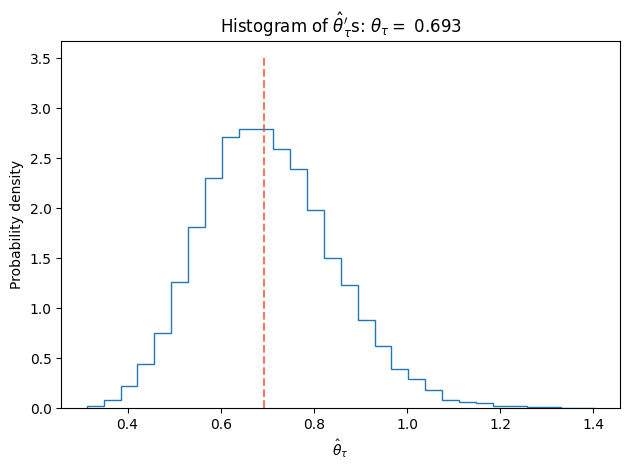

In [9]:
fig_theta_tau_hat_hist, ax = plt.subplots()

n, bins, patches = ax.hist(theta_tau_hat, bins = 30, density = True, histtype='step', align='mid') # the distribution of sample quantile

ax.plot((theta_tau, theta_tau), (0, 3.5), color='#ED4E33', alpha = 0.75, linestyle='dashed') # vertial line indicating the median
ax.set_xlabel(r'$\hat{\theta}_{\tau}$')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of ' r'$\hat{\theta}_{\tau}^{\prime}$s: '
             r'$\theta_{\tau}=$' + f' {theta_tau:.3f}') 

# Tweak spacing to prevent clipping of ylabel
fig_theta_tau_hat_hist.tight_layout()
plt.show()

### Question 3: 
For each parameterization, sample size and quantiles chosen in Question 2 (four cases in total), plot the sampling distribution of $\hat{\theta}_{\tau}$ (i.e., a variation of the figure immediately above for each of the four cases). Put your four figures in a single 4-panel graph and label all axes appropriately. Comment on any patterns you find. When do the sampling distributions look Gaussian? If they do not look Gaussian comment on any patterns of departure from this benchmark.

## The distribution of Brazilian earnings   
We will now turn our attention to the PNAD data. The PNAD is a large labor force survey, similar to the Current Population Survey (CPS) in the United States. This next block of code estimates $\theta_{\tau}$ for the logarithm of monthly earnings at $\tau=0.05,0.06,\ldots,0.95$. For each estimate it computes an order-statistic based 95% confidence interval. A simple for loop organizes the computation with the results saved in a dictionary. The dictionary data structure is convenient since it is easily converted into a _pandas_ dataframe...which will be useful for subsequent calculations.

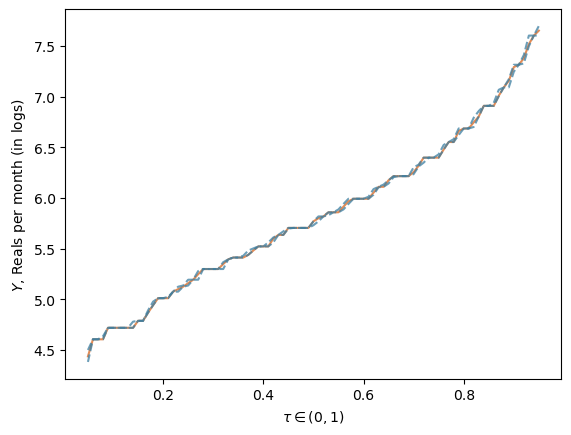

In [59]:
Y      = np.log(sample['MONTHLY_EARNINGS'])
N      = len(Y)  # the number of observations                                    
alpha  = 0.05    # set the confidence level
z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # critical value from standard normal distribution
X      = np.sort(Y) # order statistics corresponding to the sample Y

results = {'tau' : [], 'theta_tau_hat': [],'lower_CI' : [], 'upper_CI' : []}

# obtain the corresponding quantile estimator and 95% confidence intervals for each quantile tau
for tau in np.arange(0.05,0.96,0.01):
    l      = ((N*tau*(1-tau))**(1/2))*z_crit
    j      = int(np.floor(N*tau - l))
    k      = int(np.ceil(N*tau + l))
    results['tau'].append(tau)
    results['theta_tau_hat'].append(np.quantile(X, tau))
    results['lower_CI'].append(X[j-1])
    results['upper_CI'].append(X[k-1])

    
results = pd.DataFrame.from_dict(results)    

# plot the results
fig_quantile_brazil_earns, ax = plt.subplots()
                                                   
ax.set_xlabel(r'$\tau \in (0,1)$')
ax.set_ylabel(r'$Y$, Reals per month (in logs)')

plt.plot(results['tau'], results['theta_tau_hat'], color='#D9661F', alpha = 0.75) # sample tau-th quantile 
plt.plot(results['tau'], results['lower_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed') # lower bound for the 1-alpha CI
plt.plot(results['tau'], results['upper_CI'], color='#3B7EA1', alpha = 0.75, linestyle='dashed') # upper bound for the 1-alpha CI

The figure above flows our quantile estimates as well as a pointwise 95 percent confidence interval. Below the first fifteen quantile estimates and confidence intervals are printed out.

In [62]:
# Inspect the contents of the results dataframe
results.head(15)    

,tau,theta_tau_hat,lower_CI,upper_CI
0,0.05,4.436734,4.382027,4.499810
1,0.06,4.605170,4.605170,4.605170
2,0.07,4.605170,4.605170,4.605170
3,0.08,4.605170,4.605170,4.634729
4,0.09,4.718499,4.718499,4.718499
5,0.10,4.718499,4.718499,4.718499
6,0.11,4.718499,4.718499,4.718499
7,0.12,4.718499,4.718499,4.718499
8,0.13,4.718499,4.718499,4.718499
9,0.14,4.718499,4.718499,4.779123


### Question 4: 
Discuss the figure and table above. Why are some of the estimated confidence "intervals" points? What key assumption is evidently violated in our dataset? Why? How many of our confidence intervals are points? What earnings values are associated with these instances? You may place your answer in this markdown box.

## Using the Bayesian Bootstrap for Uncertainty Quantification

We can also use the Bayesian Bootstrap for quantify our uncertainty about the true value of $theta_{\tau}$. Recall that the Bayesian Bootstrap works by randomly reweighting our dataset. We perform our original computation with the reweighted data. If we do this many times we get a distribution of point estimates associated with out original procedure. We can interpret these reweighted computations as draws from the posterior distribution of our target parameter given the data.
<br>
<br>
The original sample assigned weight $\frac{1}{N}$ to each observation. The Bayesian Bootstrap assigns weights $W_1,\ldots,W_N$. These weights are positive and sum to one. The following block of code computes sample quantiles for weighted data.
### Question 5:
Add comments to the _get_quantile()_ function. Describe the input parameters as well as the outputs. How are weights handled when computing sample quantiles with weighted data? Does the approach taken in this function make sense? Do you have any thoughts on modifications? You may place your answer in this markdown box and add comments directly to the code block.

In [81]:
def get_quantile(Y, wgts, tau, alpha):

        results = {'N' : [], 'tau': [], 'theta_tau_hat': [], 'lower_CI' : [], 'upper_CI' : [], 'SE_hat' : []}
    
        N = len(Y)           # Number of observations in sample 
        Y = Y.values         # Get Y as clean 1-dimensional array
        sort_indices = np.argsort(Y)
    
        if wgts is None:
            wgts = np.ones((N,))/N          # Empirical measure if no weights provided
        else:
            wgts = wgts/np.sum(wgts)        # Normalize weights to sum to one if needed
    
        # Sort Y to get order statistics
        X = Y[sort_indices]    
       
        # Sort wgts to match order statistics
        wgts    = wgts[sort_indices]
        cum_wgt = N*np.cumsum(wgts)
        l       = np.argmax((cum_wgt+1)/(N+1)>tau)
        
        # Compute sample quantile using weight data    
        results['N'].append(N)
        results['tau'].append(tau)
        results['theta_tau_hat'].append((X[l-1]+X[l])/2)
        
        # Compute order statistic based confidence interval 
        # (NOTE: order statistics confidence intervals and SEs do not incorporate weights)
        z_crit = sp.stats.norm(loc=0, scale=1).ppf(1-alpha/2) # critical value from standard normal distribution
        l      = ((N*tau*(1-tau))**(1/2))*z_crit
        j      = max(0,int(np.floor(N*tau - l))-1)
        k      = min(N-1,int(np.ceil(N*tau + l))-1)

        results['lower_CI'].append(X[j])
        results['upper_CI'].append(X[k])
        results['SE_hat'].append(((N*(X[k]-X[j])**2)/(4*z_crit**2))**(1/2))

        return results

### Question 6:
This block of code implements the Bayesian Bootstrap to form a posterior distribution for the Brazilian earnings distribution quantiles. Add comments to this code block and discuss the figure which follows. You may place you answer in this markdown box.

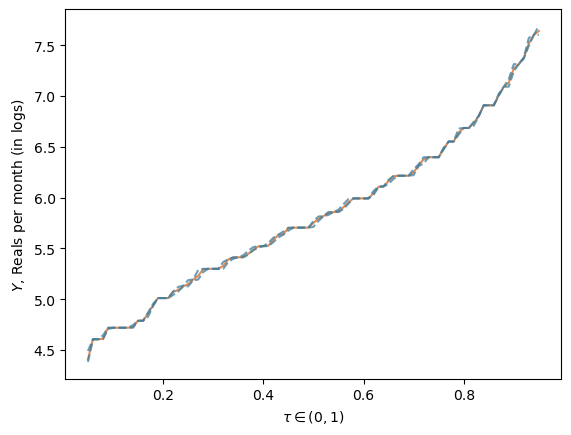

In [68]:
S = 10                                   # Number of bootstrap samples
tau_list = np.arange(0.05,0.96,0.01)     # Quantiles to estimate
BS_Results = np.empty((S,len(tau_list))) # Matrix with posterior draws of statistics of interest
N = len(Y)                               # Number of observations in dataset
alpha = 0.05

# Perform s=1,...,S bootstrap simulations    
for s in range (0,S):
    W = np.random.gamma(1.,1.,N) # Random draws of Gamma(1,1) variables
    W = W/np.sum(W)              # Converting draws to Dirichlet
    t = 0
    for tau in tau_list:
        results_s_tau = get_quantile(Y, W, tau, alpha)
        BS_Results[s,t] = results_s_tau['theta_tau_hat'][0]
        t += 1

# Summarize posterior draws and construct a figure
LCB = np.percentile(BS_Results, 2.5, axis=0)      # 2.5 percentile of Bayesian Bootstrap posterior draws
BBM = np.mean(BS_Results, axis=0)                 # Posterior mean of quantile estimates
UCB = np.percentile(BS_Results, 97.5, axis=0)     # 97.5 percentile of Bayesian Bootstrap posterior draws

# Plot posterior means and upper/lower confidence bands
fig_quantile_brazil_earns_poster, ax = plt.subplots()
                                                   
ax.set_xlabel(r'$\tau \in (0,1)$')
ax.set_ylabel(r'$Y$, Reals per month (in logs)')

plt.plot(tau_list , BBM , color='#D9661F', alpha = 0.75)                     # sample tau-th quantile 
plt.plot(tau_list , LCB , color='#3B7EA1', alpha = 0.75, linestyle='dashed') # lower bound for the 1-alpha CI
plt.plot(tau_list , UCB , color='#3B7EA1', alpha = 0.75, linestyle='dashed') # upper bound for the 1-alpha CI

## Conditional quantiles and quantile regression
We will now explore the distribution of earnings in practice conditional on years of completed schooling and age. We begin by computing a least squares fit of log earnings on years of schooling, age and age squared. We also compute a specification that includes an individual dummy variable for each of the sixteen possible schooling levels (zero to fifteen). This latter specification allows for the _mean_ effect of schooling on earnings to be non-linear.
<br>
<br>
In both the linear and dummy variable specification we are modelling how _average_ earnings varies with schooling. Quantile regression will allow us to model how the _entire distribution_ of earnings varies with schooling.
<br>
<br>
The next block of code computes the two least squares fits and plots the fitted values.

Coefficients for model [a]: 
 [ 0.14624197  0.08742562 -0.00087688]
Coefficients for model [b]: 
 [ 3.17425865e+00  3.37543591e+00  3.52052039e+00  3.65172797e+00
  3.84604065e+00  3.92693000e+00  4.02071069e+00  4.09357019e+00
  4.23939333e+00  4.31261087e+00  4.42782982e+00  4.72950148e+00
  4.96836744e+00  5.12186832e+00  5.21298598e+00  5.62293130e+00
  8.32977856e-02 -8.46141572e-04]


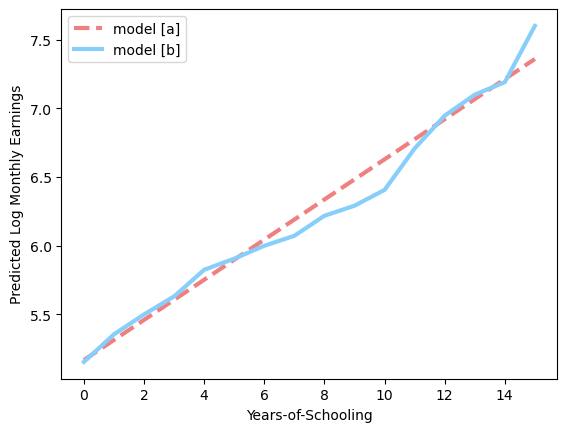

In [70]:
#Y      = np.log(sample['MONTHLY_EARNINGS'])

# (a) Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto a constant YRSSCH, AgeInDays, and AgeInDays squared
sample['AgeInDays_Sq'] = sample['AgeInDays'].values**2
regr_a = LinearRegression(fit_intercept=True).fit(sample[['YRSSCH','AgeInDays','AgeInDays_Sq']].values,Y)

# Print out the estimated regression coefficients
print("Coefficients for model [a]: \n", regr_a.coef_)

# (b) Compute the least squares fit of $\ln(MONTHLY_EARNINGS)$ onto each of the 16 dummy variables, AgeInDays, and AgeInDays squared.
dummy_sch = pd.get_dummies(sample['YRSSCH']) # create dummy variables for each of the 16 possible schooling levels
regr_b = LinearRegression(fit_intercept=False).fit(\
                                                pd.concat([dummy_sch,sample[['AgeInDays','AgeInDays_Sq']]],axis=1).values,Y)
print("Coefficients for model [b]: \n", regr_b.coef_)

# (c) Plot the regression fits in [a] and [b] on the same figure holding AgeInDays fixed at 40, but varying YRSSCH
# obtain the regression fits in [a] and [b]
YRSSCH_level = np.sort(pd.unique(sample['YRSSCH'])) # Unique schooling levels
age = 40
X_pred_a = np.vstack((YRSSCH_level,age*np.ones_like(YRSSCH_level),age**2*np.ones_like(YRSSCH_level))).T
Y_pred_a = regr_a.predict(X_pred_a)

X_pred_b = pd.concat([pd.get_dummies(YRSSCH_level),pd.Series(age*np.ones_like(YRSSCH_level)),\
           pd.Series(age**2*np.ones_like(YRSSCH_level))],axis=1)
Y_pred_b = regr_b.predict(X_pred_b)


# plot fitted regression model
plt.plot(YRSSCH_level,Y_pred_a, color="lightcoral", linewidth=3, linestyle='--')
plt.plot(YRSSCH_level,Y_pred_b, color="lightskyblue", linewidth=3)

plt.xlabel('Years-of-Schooling')
plt.ylabel('Predicted Log Monthly Earnings')

plt.legend(['model [a]','model [b]'])
plt.show()

### Question 7: 
Comment on the figure above. What patterns do you notice? You may place your answer in this markdown box.

## Estimation and inference for conditional quantiles
Estimation of conditional quantiles proceeds just like in the unconditional case, except that we only utilize observations belonging to the subpopulation of interest.
<br>
<br>
We will divide our sample of Brazilian workers into $L$ subsamples. Each sub-sample is defined by a particular combination of years of completed schooling and age. Will will work with years of schooling from zero to fifteen years and five year age range bins. This leads to more than $600$ schooling-by-age subsamples. For each such subsample we compute subsample quantiles for $\tau = 0.1, 0.25, 0.05, 0.75, 0.9$. This analysis is exactly like in the unconditional quantile case except that our "sample" is now the sub-sample of units belonging to the particular schooling-by-age cell of interest. 
<br>
<br>
In our analysis we will exclude any schooling-by-age cells with less than 30 observations. 

In [87]:
n = 0                                       # Total size of estimation sample; counter, will increment
obs_threshold = 30                          # Minimum subsample size

# Dictionary to save intermediate results for each covariate cell
results = {'YRSSCH' : [], 'Age_Range': [], 'Mid_Age': [], 'N': [], 'tau' : [], 'theta_tau_hat': [],'lower_CI' : [], 'upper_CI' : [], 'SE_hat' : []}

# iterate over all school-by-age combinations (YRSSCH_level = Unique schooling levels, defined above)
for yrssch in YRSSCH_level:  
    # start at age 20 and increment upwards by 5 years jumps
    lage = 20    
    while lage <= 60:

        # Find relevant subsample
        subsample = sample.loc[(sample['YRSSCH']==yrssch) & (sample['AgeInDays']>=lage) \
                               & (sample['AgeInDays']<lage + 5)]
        # Size of subsample
        N = len(subsample)

        # Do computations if subsample is large enough
        if N >= obs_threshold:
            n = n + N                                         # increment total sample size
            Y = np.log(subsample['MONTHLY_EARNINGS'])
            X = np.sort(Y)
            for tau in [0.1,0.25,0.5,0.75,0.9]:               # compute subsample quantiles, CIs and standard errors 
                l      = ((N*tau*(1-tau))**(1/2))*z_crit
                j      = max(0,int(np.floor(N*tau - l))-1)
                k      = min(N-1,int(np.ceil(N*tau + l))-1)
                results['YRSSCH'].append(yrssch)
                results['Age_Range'].append('[{},{})'.format(lage,lage+5))
                results['Mid_Age'].append(lage+2.5)
                results['N'].append(N)
                results['tau'].append(tau)
                results['theta_tau_hat'].append(np.quantile(X, tau))
                results['lower_CI'].append(X[j])
                results['upper_CI'].append(X[k])
                results['SE_hat'].append(((N*(X[k]-X[j])**2)/(4*z_crit**2))**(1/2))
        else:
            print("The group with year of schooling = {}, age range = [{},{}) doesn't have 30 obs".format(yrssch,lage,lage+5))
        lage = lage + 5 
results = pd.DataFrame.from_dict(results)
results['p'] = results['N']/n                                 # Proportion on observations in each cell (estimated population frequencies)

The group with year of schooling = 6, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 7, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 9, age range = [50,55) doesn't have 30 obs
The group with year of schooling = 9, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 9, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 10, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 10, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 12, age range = [20,25) doesn't have 30 obs
The group with year of schooling = 12, age range = [50,55) doesn't have 30 obs
The group with year of schooling = 12, age range = [55,60) doesn't have 30 obs
The group with year of schooling = 12, age range = [60,65) doesn't have 30 obs
The group with year of schooling = 13, age range = [20,25) doesn't have 30 obs
The group with year of schooling = 13, age range = [50,55

In [89]:
results[0:10]

,YRSSCH,Age_Range,Mid_Age,N,tau,theta_tau_hat,lower_CI,upper_CI,SE_hat,p
0,0,"[20,25)",22.5,758,0.10,3.912023,3.871201,4.094345,1.567259,0.013213
1,0,"[20,25)",22.5,758,0.25,4.442651,4.382027,4.605170,1.567259,0.013213
2,0,"[20,25)",22.5,758,0.50,4.787492,4.718499,4.787492,0.484575,0.013213
3,0,"[20,25)",22.5,758,0.75,5.298317,5.298317,5.298317,0.000000,0.013213
4,0,"[20,25)",22.5,758,0.90,5.703782,5.521461,5.768321,1.733833,0.013213
5,0,"[25,30)",27.5,850,0.10,4.094345,3.912023,4.248495,2.502538,0.014817
6,0,"[25,30)",27.5,850,0.25,4.605170,4.605170,4.700480,0.708877,0.014817
7,0,"[25,30)",27.5,850,0.50,4.948735,4.867534,5.010635,1.064323,0.014817
8,0,"[25,30)",27.5,850,0.75,5.480639,5.393628,5.521461,0.950770,0.014817
9,0,"[25,30)",27.5,850,0.90,5.991465,5.857933,6.173786,2.349180,0.014817


In [91]:
# Exclude all cells where the estimated standard error is zero.
results = results[results['SE_hat']!=0]
results['Mid_Age_Sq']= results['Mid_Age']**2

for tau in [0.1,0.25,0.5,0.75,0.9]:
    est_sample = results[results['tau']==tau]
    regr = LinearRegression(fit_intercept=True).fit(est_sample[['YRSSCH','Mid_Age','Mid_Age_Sq']],
                                                     est_sample['theta_tau_hat'],sample_weight=est_sample['p'])
    
    print('The coefficient on schooling when tau equals to {} is {}'.format(tau,regr.coef_[0]))

The coefficient on schooling when tau equals to 0.1 is 0.1377017524916074
The coefficient on schooling when tau equals to 0.25 is 0.1412500910977825
The coefficient on schooling when tau equals to 0.5 is 0.15094635517504196
The coefficient on schooling when tau equals to 0.75 is 0.15343274340973695
The coefficient on schooling when tau equals to 0.9 is 0.15174539163430031


### Question 8: 
Plot your estimated conditional quantile regression functions at $\tau=0.1,0.25,0.5,0.75,0.9$ in Years-of-Schooling by Log-Earnings space. You may fix age at 40 years (as one done in the least squares plots earlier). Comment on any patterns you see. Do you have any thoughts for why high quantiles increase more sharply with schooling than lower ones?

## Extra Credit
1. Use the Bayesian Bootstrap to construct confidence intervals for the schooling coefficients at the $\tau=0.1,0.25,0.5,0.75,0.9$. This is not a straightforward exercise and would be a considerable accomplishment to complete. If you complete this extra credit I will increase the value of your lowest (non-dropped) homework score by three points (e.g., from 7 to 10). A score greater than 10 is allowed.
2. Write a short 2-3 page reference report on an article of your choosing. This could be an academic article with statistical content, or even a popular article that engages, whether directly or tangentially, with course content. How might the information in the article help you answer questions which have meaning to you? How might you use ideas learned in this course (or other MaCSS courses) to assess the claims made in the article. Your writing should be clear and concise, but otherwise can be informal. I am most interested in learning your thoughts. If you complete this assignment it will count as your "scribing" score; otherwise your homework aggregate will be upweighted.